## XGBoost의 파라미터 튜닝 가이드

### 1. XGBoost의 장점
1. Regularization:
 - 표준 GBM 구현은 XGBoost와 같은 규제항이 없다.
 - XGBoost는 규제항이 있는 boosting 기술이라 할 수 있다.
2. 병렬처리
 - 병렬처리를 구현하여 기존 GBM보다 빠르다.
 - 하둡에서도 구동이 가능하여 spark에서 이용할 수 있다.
3. 높은 유연성
 - 비용함수와 평가 척도에 대한 사용자 설정이 가능하다.
 - 이로인해 전혀 다른 차원의 문제를 해결하는 데 제약이 없다.
4. 결측치의 처리
 - 결측치 처리를 위한 내부 루틴을 가지고 있다.
 - 결측에 대한 처리 방법을 매개변수로 전달하여, 처리할 수 있다.
5. 나무 가지치기
 - GBM은 각 split에서 마이너스 gain을 가지면 가지뻗기를 중단한다.
 - 반면 XGBoost는 지정된 max_depth까지 가지뻗기한 후, 다시 gain이 +가 되도록 가지치기한다. 
 - 특히나, -2 gain 이후, 추가적인 가지뻗기로 +10의 gain을 얻을 기회를 갖는다.
6. 내장 교차평가(Cross Validation)
 - 각 iteration마다 교차평가가 가능하도록 하여, iteration 중 최적 모델을 얻을 수 있다.
7. 모델의 지속성
 - 이전 최종 iteration에서 학습을 재시작할 수 있다. online-update 가능.
 - 이점에 있어서는 sklearn의 GBM도 같다.
 
### 2. XGBoost Parameters
XGBoost 소개 문서를 참조한다.

### 3. 파라미터 튜닝 예


In [1]:
import numpy as np
import gzip
import pandas as pd

In [2]:
import xgboost as xgb
xgb.__version__

'1.1.1'

In [3]:
df = pd.read_csv('births_transformed.csv.gz', 
                 compression='gzip', 
                 header=0, error_bad_lines=False)
df[:3]

,INFANT_ALIVE_AT_REPORT,BIRTH_PLACE,MOTHER_AGE_YEARS,FATHER_COMBINED_AGE,CIG_BEFORE,CIG_1_TRI,CIG_2_TRI,CIG_3_TRI,MOTHER_HEIGHT_IN,MOTHER_PRE_WEIGHT,MOTHER_DELIVERY_WEIGHT,MOTHER_WEIGHT_GAIN,DIABETES_PRE,DIABETES_GEST,HYP_TENS_PRE,HYP_TENS_GEST,PREV_BIRTH_PRETERM
0,0,1,29,99,0,0,0,0,99,999,999,99,0,0,0,0,0
1,0,1,22,29,0,0,0,0,65,180,198,18,0,0,0,0,0
2,0,1,38,40,0,0,0,0,63,155,167,12,0,0,0,0,0


In [6]:
df.BIRTH_PLACE.value_counts()

1    44558
4      327
3      224
2      136
7       91
5       74
6       11
9        8
Name: BIRTH_PLACE, dtype: int64

In [4]:
df.BIRTH_PLACE = df.BIRTH_PLACE.astype(str)
df.BIRTH_PLACE.describe

<bound method NDFrame.describe of 0        1
1        1
2        1
3        1
4        1
        ..
45424    1
45425    1
45426    1
45427    1
45428    1
Name: BIRTH_PLACE, Length: 45429, dtype: object>

In [7]:
df.INFANT_ALIVE_AT_REPORT.value_counts()

1    23349
0    22080
Name: INFANT_ALIVE_AT_REPORT, dtype: int64

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
len(df.columns)
colnames = df.columns
colnames[3]

'FATHER_COMBINED_AGE'

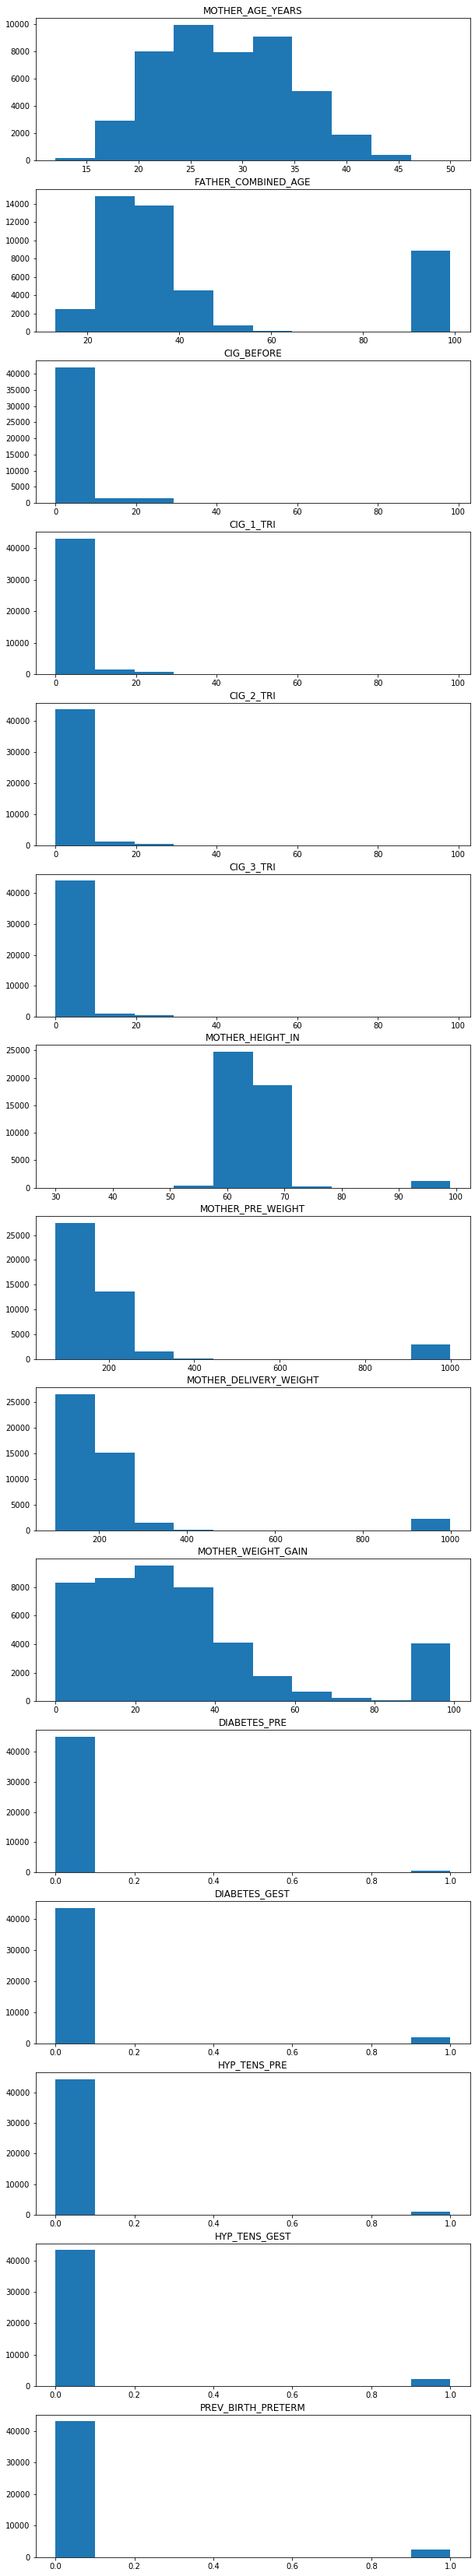

In [10]:
fig, axes = plt.subplots(len(colnames)-2, 1, figsize=(10, 60))
for i in range(len(colnames)-2):
    axes[i].hist(df[colnames[i+2]], bins=10)
    axes[i].set_title(colnames[i+2])

In [11]:
df_dummy = pd.get_dummies(df, columns = ["BIRTH_PLACE"])
df_dummy.head

<bound method NDFrame.head of        INFANT_ALIVE_AT_REPORT  MOTHER_AGE_YEARS  FATHER_COMBINED_AGE  \
0                           0                29                   99   
1                           0                22                   29   
2                           0                38                   40   
3                           0                39                   42   
4                           0                18                   99   
...                       ...               ...                  ...   
45424                       1                25                   29   
45425                       1                25                   39   
45426                       1                31                   99   
45427                       1                24                   24   
45428                       1                29                   42   

       CIG_BEFORE  CIG_1_TRI  CIG_2_TRI  CIG_3_TRI  MOTHER_HEIGHT_IN  \
0               0          0     

- "BIRTH_PLACE" 변수로 부터 8개의 one-hot encode 변수를 생성한다.
- "BIRTH_PLACE_1" ... "BIRTH_PLACE_7", "BIRTH_PLACE_9"의 변수가 새로 생성되고,
- "BIRTH_PLACE" 변수는 제거된 것을 확인할 수 있다.

In [12]:
from sklearn.model_selection import train_test_split

dtrain, dtest = train_test_split(df_dummy, test_size=0.3, random_state=0, 
                                 stratify=df_dummy["INFANT_ALIVE_AT_REPORT"])
target = "INFANT_ALIVE_AT_REPORT"
# dtrain["INFANT_ALIVE_AT_REPORT"].describe()

In [14]:
from sklearn import metrics
from sklearn.model_selection import GridSearchCV   #Perforing grid search

In [15]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, 
             cv_folds=5, early_stopping_rounds=50, dtest=None):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['INFANT_ALIVE_AT_REPORT'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Train Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['INFANT_ALIVE_AT_REPORT'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['INFANT_ALIVE_AT_REPORT'], dtrain_predprob))
    
    if dtest is not None:
        dtest_predictions = alg.predict(dtest[predictors])
        dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
        print ("\nModel Test Report")
        print ("Accuracy : %.4g" % metrics.accuracy_score(dtest['INFANT_ALIVE_AT_REPORT'].values, dtest_predictions))
        print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtest['INFANT_ALIVE_AT_REPORT'], dtest_predprob))
    
    
    xgb.plot_importance(alg)
    plt.ylabel('Feature Importance Score')

#### (0) 파라미터 튜닝을 위한 일반적인 접근방법
일반적인 GBM 접근법과 유사한 XGBoosting의 파라미터 튜닝 절차는 다음과 같다 :
1. 상대적으로 높은 **학습률**(learning rate)을 선택한다.
 - 기본 학습률은 0.1이지만, 문제에 따라  0.05 ~ 0.3 정도에서 선택한다.
 - 학습률에 따른 최적 **tree의 수**를 선택하는 것이 일반적이다.
 - 이때 xgboosting.cv를 사용하면 매 iteration 마다 최적 tree의 수를 얻을 수 있다.
2. Tree에 특정된 파라미터 튜닝
 - 1에서 결정된 learning rate와 tree의 수에 따른 최적 tree 파라미터를 설정한다.
 - 예 : max_depth, min_child_weight, gamma, subsample, colsample_bytree 등
3. 정규화 파라미터$(\lambda, \alpha)$ 튜닝
 - L1, L2 Regularation factor를 설정한다.
4. 학습률을 좀 더 낮추면서, 1 ~ 3 까지의 튜닝 과정을 반복한다.

#### (1) Step 1 : 학습률과 트리의 수를 고정하기
boosting 파라미터를 결정하기 위해, 아래와 같은 초기값을 가지고 시작하자.

1. max_depth = 5 : 3 ~ 10의 값이 적당한데, 5의 값으로 시작했다.
2. min_child_weight = 1 : 불균형 class 문제일 수록 이 값을 작게 설정해야 한다.
3. gamma = 0 : 보통은 0.1 ~ 0.2의 값에서부터 튜닝을 시작하지만, 나중에 튜닝하자.
4. subsample, colsample_bytree = 0.8 : 보통 0.5 ~ 0.9의 값을 가지고 시작한다.
 - 하지만, test set을 별도로 구비한 경우는 1.0으로 시작하는 것이 적절한다.
5. scale_pos_weight = 1 : 불균형 class 문제인 경우는 크거나 작게 설정하는 것이 좋다.
 - 그냥 AUR 만으로 판정할 수도 있다.
 
이와 같은 설정은 모두 초기값일 뿐이다. 이 값들은 나중에 모두 튜닝할 것이다. 일단, **학습률을 0.1로 설정한 상태에서 tree의 수를 1000**으로 결정하자.

In [16]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4


Model Train Report
Accuracy : 0.7471
AUC Score (Train): 0.816350

Model Test Report
Accuracy : 0.7259
AUC Score (Train): 0.784820


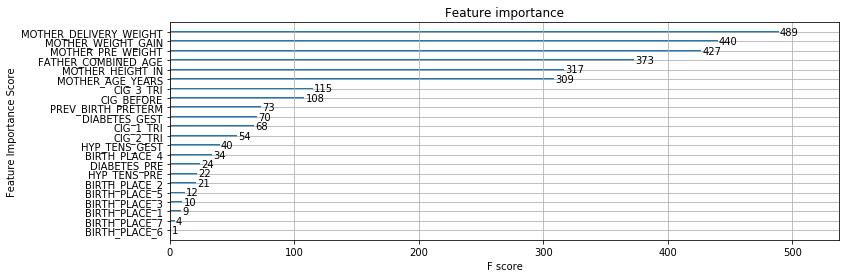

In [18]:
predictors = [x for x in dtrain.columns if x not in [target]]
xgb1 = xgb.XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8, 
    colsample_bytree=0.8,
    tree_method="exact",
    objective= 'binary:logistic',
    scale_pos_weight=1,
    seed=27)
modelfit(xgb1, dtrain, predictors, dtest=dtest)

predict_proba 메소드는 label 0과 1에 대한 prediction probability를 (n_samples, 2) shape의 np.array로 리턴한다.

- 아래 AUC 계산을 위해서는 단지 label=1인 primary class에 대한 probability만 필요하다.

In [121]:
dtest_predictions = xgb1.predict(dtest[predictors])
dtest_predprob = xgb1.predict_proba(dtest[predictors])[:,1]

#Print model report:
print ("\nModel Report")
print ("Accuracy : %.4g" % metrics.accuracy_score(dtest['INFANT_ALIVE_AT_REPORT'].values, dtest_predictions))
print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtest['INFANT_ALIVE_AT_REPORT'], dtest_predprob))


Model Report
Accuracy : 0.726
AUC Score (Train): 0.785690


C:\Users\great\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [20]:
xgb1.get_params()['n_estimators']

120

#### (2) Step 2: max_depth, min_child_weight 튜닝
먼저 모델 성능에 가장 큰 영향을 줄 수 있는 파라미터를 넓은 영역에 걸쳐 튜닝하자. 시간이 많이 걸리므로, iteration의 수를 줄여보자.

In [24]:
import time
start = time.time()
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, 
 n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(dtrain[predictors],dtrain[target])
print(time.time() - start)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

C:\Users\CPB-Han01\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


76.37477993965149


({'mean_fit_time': array([2.9464335 , 2.61492276, 2.62193608, 3.86833754, 4.20243998,
         4.23065667, 6.03821559, 5.50712342, 5.46033101, 7.07623348,
         7.28184438, 6.51374726]),
  'std_fit_time': array([0.13903093, 0.06032581, 0.15145755, 0.1821512 , 0.30417409,
         0.15833206, 0.43041164, 0.23200703, 0.20190164, 0.42030203,
         0.13267835, 0.4231559 ]),
  'mean_score_time': array([0.03889527, 0.03271275, 0.03311167, 0.04108977, 0.04348359,
         0.05046487, 0.05516453, 0.05186133, 0.05365648, 0.06652408,
         0.06462731, 0.06084633]),
  'std_score_time': array([0.00454905, 0.00132321, 0.00159552, 0.00146553, 0.00205316,
         0.0042118 , 0.00417323, 0.00126116, 0.00146626, 0.00263273,
         0.00222098, 0.0047167 ]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
         

- 확실히 iteration 즉, tree의 수가 줄어드니 AUR 값이 낮아졌다.
- 이제 위에서 수행한 CPU 속도와 GPU 속도를 비교해보자. iteraton의 수를 약간 늘려보겠다.

In [25]:
start = time.time()
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, 
 n_estimators=200, max_depth=5, min_child_weight=1, 
 gamma=0, subsample=0.8, colsample_bytree=0.8, tree_method="gpu_hist",
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(dtrain[predictors],dtrain[target])
print(time.time() - start)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

C:\Users\CPB-Han01\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\CPB-Han01\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


88.22900867462158


({'mean_fit_time': array([ 1.90609312,  1.57711058,  1.50279903,  3.0741693 ,  2.89012589,
          2.80064502,  6.81158109,  6.00078812,  5.51606288, 14.55545816,
         11.10259366,  8.37210422]),
  'std_fit_time': array([0.29813344, 0.10927328, 0.04597002, 0.05852614, 0.04457694,
         0.04650705, 0.08394919, 0.1266072 , 0.07466739, 0.2918125 ,
         0.1923584 , 1.18189632]),
  'mean_score_time': array([0.03410883, 0.03141804, 0.02892308, 0.03729796, 0.04089146,
         0.0404922 , 0.06103764, 0.05385585, 0.05565062, 0.06522574,
         0.06961403, 0.06104007]),
  'std_score_time': array([0.00291778, 0.00596684, 0.0071084 , 0.00370589, 0.00574632,
         0.00648124, 0.00851942, 0.00315404, 0.01182418, 0.00597034,
         0.00364545, 0.00977358]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?

- 데이터량이 작은 경우, gpu를 사용하는 것이 더 속도가 느릴 수도 있다.
- 그러나 iteration이 늘어난 것과 비교해보면, 더 빠르다고 판단할 수 있다.
- 특히나, "gpu_exact"는 더 느린 결과가 나타날 수 있다.

이를 다음과 같은 range를 통해 확인해본다.

In [26]:
start = time.time()
param_test1 = {
 'max_depth':[3,4,5],
 'min_child_weight':[1,2,3]
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, n_estimators=200, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, tree_method="gpu_hist",
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(dtrain[predictors],dtrain[target])
print(time.time() - start)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

C:\Users\CPB-Han01\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


25.996331930160522


({'mean_fit_time': array([1.6011601 , 1.54959579, 1.57113204, 2.1165545 , 2.09667869,
         2.06098161, 3.00554914, 2.96467705, 2.48044624]),
  'std_fit_time': array([0.01980583, 0.02674902, 0.02277087, 0.06025001, 0.04823099,
         0.03292973, 0.05981005, 0.05344507, 0.581512  ]),
  'mean_score_time': array([0.03051195, 0.03310986, 0.03271251, 0.03350415, 0.03390927,
         0.03291163, 0.04029489, 0.0418819 , 0.03567567]),
  'std_score_time': array([0.00431331, 0.00490241, 0.00270578, 0.00857527, 0.00398945,
         0.00538927, 0.00965875, 0.00471794, 0.0084331 ]),
  'param_max_depth': masked_array(data=[3, 3, 3, 4, 4, 4, 5, 5, 5],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[1, 2, 3, 1, 2, 3, 1, 2, 3],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         

- 최적인 조합은 {'max_depth': 3, 'min_child_weight': 3}로 판단된다.

최적의 값에 가까워지면서, gain의 값의 차이는 매우 적다. max_depth의 3 근방에서의 최대값이 모호해보인다. 한번만 더 확인해보자.

In [28]:
start = time.time()
param_test1 = {
 'max_depth':[2,3,4],
 'min_child_weight':[1,2,3]
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, n_estimators=200, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, tree_method="gpu_hist",
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(dtrain[predictors],dtrain[target])
print(time.time() - start)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

C:\Users\CPB-Han01\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


21.761050701141357


({'mean_fit_time': array([1.4912097 , 1.23830023, 1.22307405, 1.53473821, 1.52998328,
         1.56781025, 2.13460374, 2.081671  , 1.78276296]),
  'std_fit_time': array([0.1790413 , 0.01832408, 0.04051915, 0.0347091 , 0.08343652,
         0.05369693, 0.08103989, 0.01977378, 0.39880797]),
  'mean_score_time': array([0.03849669, 0.02633052, 0.0229383 , 0.0279254 , 0.02653036,
         0.02912135, 0.03640451, 0.03251314, 0.03042526]),
  'std_score_time': array([0.00919592, 0.00632824, 0.00454732, 0.00398948, 0.00482865,
         0.00424999, 0.00295994, 0.0017386 , 0.00787079]),
  'param_max_depth': masked_array(data=[2, 2, 2, 3, 3, 3, 4, 4, 4],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[1, 2, 3, 1, 2, 3, 1, 2, 3],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         

- 역시 최적인 조합은 {'max_depth': 3, 'min_child_weight': 3}로 판단된다.

이제 위에서 고정한 {'max_depth': 3, 'min_child_weight': 2}을 base로하여 gamma의 값을 튜닝해보자.

#### (3) Step 3: Tune gamma


In [30]:
start = time.time()
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, n_estimators=200, max_depth=3,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8, tree_method="gpu_hist",
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(dtrain[predictors],dtrain[target])
print(time.time() - start)
gsearch3.cv_results_ , gsearch3.best_params_, gsearch3.best_score_

C:\Users\CPB-Han01\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


13.185024976730347


({'mean_fit_time': array([1.90922108, 1.58356123, 1.58417149, 1.53451462, 1.33469486]),
  'std_fit_time': array([0.18845615, 0.03038948, 0.02302278, 0.02400047, 0.39487795]),
  'mean_score_time': array([0.03909564, 0.02912273, 0.03470683, 0.02991538, 0.02952142]),
  'std_score_time': array([0.00513993, 0.00255384, 0.00674669, 0.00554428, 0.00859324]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.78936037, 0.78894244, 0.78898351, 0.7888699 , 0.78887624]),
  'split1_test_score': array([0.78836445, 0.78800045, 0.78829146, 0.78833679, 0.78846584]),
  'split2_test_score': array([0.79336307, 0.79366467, 0.79366467, 0.7936663 , 0.79366789]),
  'split3_test_score': array([0.78444643, 0.78444643, 0.78444574, 0.78444574, 0.78444574]),

- gamma에 의한 gain의 변동이 없는 것으로 보여진다.

gamma의 scale을 좀 더 낮게하여 검색해보자.

In [32]:
start = time.time()
param_test3 = {
 'gamma':[i/100.0 for i in range(7,10)]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=200, max_depth=3,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8, tree_method="gpu_hist",
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(dtrain[predictors],dtrain[target])
print(time.time() - start)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

C:\Users\CPB-Han01\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


6.791208744049072


({'mean_fit_time': array([1.5801259 , 1.62279487, 1.37314219]),
  'std_fit_time': array([0.01717816, 0.01287451, 0.17605579]),
  'mean_score_time': array([0.03271208, 0.03311172, 0.0339098 ]),
  'std_score_time': array([0.0058629 , 0.00554923, 0.00710905]),
  'param_gamma': masked_array(data=[0.07, 0.08, 0.09],
               mask=[False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.07}, {'gamma': 0.08}, {'gamma': 0.09}],
  'split0_test_score': array([0.78906095, 0.78910356, 0.78910841]),
  'split1_test_score': array([0.78790049, 0.78770291, 0.78770291]),
  'split2_test_score': array([0.7930686 , 0.7930686 , 0.79306791]),
  'split3_test_score': array([0.7846217, 0.7846217, 0.7846217]),
  'split4_test_score': array([0.79787508, 0.79778255, 0.79778255]),
  'mean_test_score': array([0.79050537, 0.79045586, 0.79045669]),
  'std_test_score': array([0.00456885, 0.00455964, 0.00455927]),
  'rank_test_score': array([1, 3, 2])},
 {'gamma': 0.07},

In [33]:
start = time.time()
param_test3 = {
 'gamma':[i/100.0 for i in range(4,7)]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=200, max_depth=3,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8, tree_method="gpu_hist",
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(dtrain[predictors],dtrain[target])
print(time.time() - start)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

C:\Users\CPB-Han01\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


6.937610626220703


({'mean_fit_time': array([1.6850822 , 1.59966211, 1.36638303]),
  'std_fit_time': array([0.02551988, 0.03162511, 0.21467878]),
  'mean_score_time': array([0.03949604, 0.03470678, 0.03051457]),
  'std_score_time': array([0.00562661, 0.0095956 , 0.00712989]),
  'param_gamma': masked_array(data=[0.04, 0.05, 0.06],
               mask=[False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.04}, {'gamma': 0.05}, {'gamma': 0.06}],
  'split0_test_score': array([0.78911469, 0.78911469, 0.78906095]),
  'split1_test_score': array([0.7878949 , 0.7878949 , 0.78790049]),
  'split2_test_score': array([0.7930686, 0.7930686, 0.7930686]),
  'split3_test_score': array([0.78436464, 0.78436464, 0.7846217 ]),
  'split4_test_score': array([0.79807653, 0.79786929, 0.79786929]),
  'mean_test_score': array([0.79050387, 0.79046242, 0.79050421]),
  'std_test_score': array([0.00469786, 0.00463131, 0.00456698]),
  'rank_test_score': array([2, 3, 1])},
 {'gamma': 0.06},

- 역시 gamma에 의한 gain의 변동이 없는 것으로 보여진다.

#### (4) Step 4: Tune subsample and colsample_bytree
다음은 subsample과 colsample_bytree에 변화를 주어 튜닝해보자.

In [34]:
start = time.time()
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=200, max_depth=3,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8, tree_method="gpu_hist",
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(dtrain[predictors],dtrain[target])
print(time.time() - start)
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

C:\Users\CPB-Han01\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


31.985571146011353


({'mean_fit_time': array([1.56725488, 1.52314215, 1.53969903, 1.57261891, 1.42449512,
         1.48951082, 1.55893459, 1.5832324 , 1.43540778, 1.46844797,
         1.56616387, 1.56144023, 1.48762884, 1.50020766, 1.52018223,
         1.40099306]),
  'std_fit_time': array([0.10051622, 0.05689671, 0.02584813, 0.04051941, 0.05612192,
         0.0495471 , 0.00457958, 0.01878837, 0.05501123, 0.03698336,
         0.04223426, 0.06127944, 0.04466073, 0.02708137, 0.03113456,
         0.18803844]),
  'mean_score_time': array([0.03011951, 0.03271198, 0.02593098, 0.02692714, 0.02812443,
         0.02712736, 0.03111672, 0.02692709, 0.02713308, 0.02812924,
         0.02951984, 0.02822375, 0.02792454, 0.03011837, 0.03211408,
         0.02553167]),
  'std_score_time': array([0.00486129, 0.00400946, 0.00260135, 0.00309084, 0.00572465,
         0.00434272, 0.00569154, 0.00383636, 0.0019309 , 0.00352993,
         0.00809175, 0.00504198, 0.00236151, 0.00659733, 0.00277842,
         0.00325291]),
  'param_c

- best parameters는 {'colsample_bytree': 0.7, 'subsample': 0.6}이다.
- colsample_bytree는 0.6 ~ 0.7, subsample은 0.9 이상이 좋은 경향이 있다.

이러한 insight에 맞추어 탐색 영역을 재조정해보자.

In [35]:
start = time.time()
param_test4 = {
 'subsample':[i/100.0 for i in range(60,64)],
 'colsample_bytree':[i/100.0 for i in range(90,95)]
}
gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=200, max_depth=3,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8, tree_method="gpu_hist",
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(dtrain[predictors],dtrain[target])
print(time.time() - start)
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

C:\Users\CPB-Han01\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


38.87879419326782


({'mean_fit_time': array([1.5437233 , 1.49699016, 1.45013065, 1.48525085, 1.48598742,
         1.46370091, 1.47568302, 1.49580693, 1.49678092, 1.46531401,
         1.4721067 , 1.53223977, 1.48313794, 1.53226762, 1.48273792,
         1.48476186, 1.48766155, 1.51436   , 1.53706532, 1.38894153]),
  'std_fit_time': array([0.05656741, 0.05079068, 0.04092228, 0.05005269, 0.05306563,
         0.06701857, 0.03361292, 0.07140406, 0.02764912, 0.04296756,
         0.07288055, 0.03875009, 0.03590571, 0.02255077, 0.04372739,
         0.04461929, 0.01359142, 0.04394852, 0.04186497, 0.13269744]),
  'mean_score_time': array([0.03271456, 0.03271346, 0.02952447, 0.03371024, 0.0272346 ,
         0.02832403, 0.03191504, 0.02912259, 0.0297204 , 0.02473297,
         0.0272295 , 0.02872314, 0.02652869, 0.02732682, 0.02832417,
         0.0341116 , 0.03131623, 0.03191419, 0.02652936, 0.02792549]),
  'std_score_time': array([0.00700765, 0.00330171, 0.00440116, 0.01172283, 0.00147669,
         0.0030003 , 0.0065

- 그냥 best parameters는 {'colsample_bytree': 0.6, 'subsample': 0.9}로 정하자.

#### (5) Step 5: Tuning Regularization Parameters
많은 사람들이 잘 사용하지 않지만, 규제항을 적절히 사용하는 것은 overfit을 방지하는 데 좋은 솔루션이다.

reg_alpha=0는 L1, reg_lambda=1는 L2 규제 항에 대한 가중치이다. 이제 이 값들을 조정해보자.

In [37]:
start = time.time()
param_test6 = {
 'reg_alpha':[1e-2, 1e-1, 1, 10],
 'reg_lambda':[1e-2, 1e-1, 1, 10]
}
gsearch6 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=200, max_depth=3,
 min_child_weight=3, gamma=0, subsample=0.63, colsample_bytree=0.9, tree_method="gpu_hist",
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(dtrain[predictors],dtrain[target])
print(time.time() - start)
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

C:\Users\CPB-Han01\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


31.3359432220459


({'mean_fit_time': array([1.55696549, 1.54724045, 1.56001487, 1.53062825, 1.47977071,
         1.50569739, 1.48683963, 1.50481687, 1.46574025, 1.46867971,
         1.4846776 , 1.44693995, 1.4812551 , 1.49424334, 1.45812922,
         1.41844177]),
  'std_fit_time': array([0.02634244, 0.03097262, 0.03867177, 0.02396635, 0.07444089,
         0.05636101, 0.02773557, 0.06081037, 0.0488278 , 0.06146416,
         0.03511485, 0.02205645, 0.01929369, 0.05004625, 0.01635921,
         0.1123293 ]),
  'mean_score_time': array([0.0331111 , 0.03630285, 0.03989215, 0.03550506, 0.02493339,
         0.03111634, 0.02553163, 0.03071818, 0.0297235 , 0.02971969,
         0.02433543, 0.02852683, 0.03171535, 0.0277276 , 0.03191547,
         0.0251317 ]),
  'std_score_time': array([0.00849544, 0.00354567, 0.01009632, 0.01302726, 0.00227423,
         0.0072021 , 0.00173829, 0.00353505, 0.00291868, 0.00452121,
         0.00286337, 0.00293568, 0.00529209, 0.00369808, 0.00958654,
         0.00452161]),
  'param_r

In [111]:
start = time.time()
param_test6 = {
 'reg_alpha':[0.05, 0.1, 0.3, 0.6],
 'reg_lambda':[0.5, 1.0, 3.0, 6.0]
}
gsearch6 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=200, max_depth=3,
 min_child_weight=3, gamma=0, subsample=0.9, colsample_bytree=0.6, tree_method="gpu_hist",
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(dtrain[predictors],dtrain[target])
print(time.time() - start)
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

55.923624753952026


C:\Users\great\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\great\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\great\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\great\Anaconda3\lib\site-packages\sklearn\util

({'mean_fit_time': array([1.7869957 , 2.49260583, 2.47765045, 2.44382648, 2.46344023,
         2.4658421 , 2.48055248, 2.4617393 , 2.48635674, 2.45983791,
         2.49476247, 2.43251834, 2.45763636, 2.47394786, 2.5843267 ,
         2.28381314]),
  'std_fit_time': array([0.74071843, 0.05579983, 0.07117508, 0.04430031, 0.05270077,
         0.04558259, 0.0394976 , 0.07716433, 0.04533129, 0.04423928,
         0.05033967, 0.03248927, 0.02535824, 0.01580529, 0.19617903,
         0.49431751]),
  'mean_score_time': array([0.01841321, 0.01741219, 0.01771274, 0.01811299, 0.01941376,
         0.01911335, 0.02041435, 0.02141495, 0.01831293, 0.02041435,
         0.02121515, 0.01961379, 0.01891322, 0.01841292, 0.02581778,
         0.0161119 ]),
  'std_score_time': array([0.00265544, 0.00124181, 0.00081262, 0.00106837, 0.00334   ,
         0.00168658, 0.00438922, 0.00272964, 0.00081295, 0.00231244,
         0.00315819, 0.00086076, 0.00058347, 0.00080053, 0.01150441,
         0.00251883]),
  'param_r

- best parameters는 {'reg_alpha': 0.05, 'reg_lambda': 6.0}
- 모두 edge에 위치해 있어서 추가적인 검색이 필요하다.

In [112]:
start = time.time()
param_test6 = {
 'reg_alpha':[0.04, 0.05, 0.06],
 'reg_lambda':[5.0, 6.0, 7.0]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=200, max_depth=3,
 min_child_weight=2, gamma=0, subsample=0.9, colsample_bytree=0.6, tree_method="gpu_hist",
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(dtrain[predictors],dtrain[target])
print(time.time() - start)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

32.8480658531189


C:\Users\great\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.79035, std: 0.00461, params: {'reg_alpha': 0.04, 'reg_lambda': 5.0},
  mean: 0.79029, std: 0.00455, params: {'reg_alpha': 0.04, 'reg_lambda': 6.0},
  mean: 0.79033, std: 0.00443, params: {'reg_alpha': 0.04, 'reg_lambda': 7.0},
  mean: 0.79035, std: 0.00461, params: {'reg_alpha': 0.05, 'reg_lambda': 5.0},
  mean: 0.79058, std: 0.00436, params: {'reg_alpha': 0.05, 'reg_lambda': 6.0},
  mean: 0.79027, std: 0.00453, params: {'reg_alpha': 0.05, 'reg_lambda': 7.0},
  mean: 0.79034, std: 0.00458, params: {'reg_alpha': 0.06, 'reg_lambda': 5.0},
  mean: 0.79048, std: 0.00444, params: {'reg_alpha': 0.06, 'reg_lambda': 6.0},
  mean: 0.79026, std: 0.00454, params: {'reg_alpha': 0.06, 'reg_lambda': 7.0}],
 {'reg_alpha': 0.05, 'reg_lambda': 6.0},
 0.7905824609198235)

In [122]:
gsearch6.get_params()

{'cv': 5,
 'error_score': 'raise',
 'estimator__base_score': 0.5,
 'estimator__booster': 'gbtree',
 'estimator__colsample_bylevel': 1,
 'estimator__colsample_bytree': 0.6,
 'estimator__gamma': 0,
 'estimator__learning_rate': 0.1,
 'estimator__max_delta_step': 0,
 'estimator__max_depth': 3,
 'estimator__min_child_weight': 2,
 'estimator__missing': None,
 'estimator__n_estimators': 200,
 'estimator__n_jobs': 1,
 'estimator__nthread': 4,
 'estimator__objective': 'binary:logistic',
 'estimator__random_state': 0,
 'estimator__reg_alpha': 0,
 'estimator__reg_lambda': 1,
 'estimator__scale_pos_weight': 1,
 'estimator__seed': 27,
 'estimator__silent': True,
 'estimator__subsample': 0.9,
 'estimator__tree_method': 'gpu_hist',
 'estimator': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_delta_step=0,
        max_depth=3, min_child_weight=2, missing=None, n_estimators=200,
        n_jobs=1, nthread=4, objective='b

- 다행히 이전 결과와 같이 best parameters는 {'reg_alpha': 0.05, 'reg_lambda': 6.0}.
- 따라서 추가적인 탐색은 중지한다.

>참고로 return_train_score가 True이거나 warn인 경우, 매우 느리게 동작한다. sklearn 0.21에서는 이 옵션이 default로 False가 될 것이다. 가급적 False로 설정하고 구동하는 것이 좋겠다.

#### (6) Step 6: Reducing Learning Rate
이제 최종적으로 학습률을 줄이고, iteration의 수를 늘려보자.


Model Train Report
Accuracy : 0.7397
AUC Score (Train): 0.805969


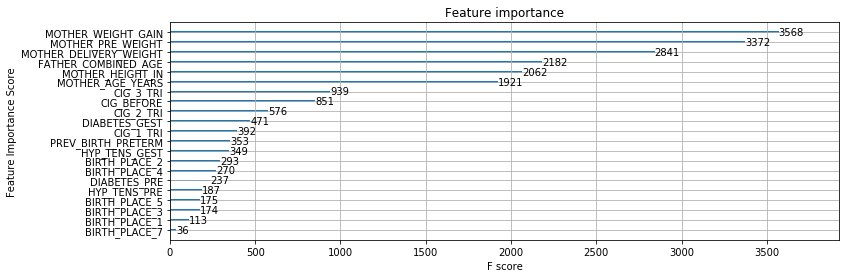

In [39]:
xgb_f = xgb.XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=3,
 min_child_weight=2,
 gamma=0,
 subsample=0.9,
 colsample_bytree=0.6,
 tree_method="gpu_hist",
 reg_alpha=0.05,
 reg_lambda=6.0,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb_f, dtrain, predictors)

In [40]:
dtest_predictions = xgb_f.predict(dtest[predictors])
dtest_predprob = xgb_f.predict_proba(dtest[predictors])[:,1]

#Print model report:
print ("\nModel Test Report")
print ("Accuracy : %.4g" % metrics.accuracy_score(dtest['INFANT_ALIVE_AT_REPORT'].values, dtest_predictions))
print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtest['INFANT_ALIVE_AT_REPORT'], dtest_predprob))


Model Test Report
Accuracy : 0.728
AUC Score (Train): 0.785959
